## Storm Mode/Precipitation Type Classification Output for 3D Reflectivity from derived dBZ of WRF Simulations. 

**Based on the Convective/Stratiform separation on the 12 $\sigma$ level of reflectivity.**

**Calculate the max. composite reflectivity instead of REFLC_10CM from CONUS1 runs.**

**Storm Mode Classification starts from the Composite dBZ (Rain Area) identification, and add another mode: Ordinary (Non-Deep) Convective Cores (OCC) to represent shallow conveciton.**

**Output the Storm Mode Classification information (1:DCC; 2:OCC; 3:WCC; 4:DWCC; 5:BSR) to CONUS dBZ data.**

**For [High Resolution WRF Simulations of the Current and Future Climate of North America](https://rda.ucar.edu/datasets/ds612.0/).**

**Hungjui Yu 20211217**

In [8]:
import sys
import time
import datetime as dt
import pytz
from netCDF4 import Dataset # MFDataset
import numpy as np
import xarray as xr
import pandas as pd
import wrf
from wrf import (getvar, interplevel, destagger)

import cartopy.crs as ccrs
import cartopy.feature as cfeat
import matplotlib as mpl
import matplotlib.pyplot as plt

modules_path = '/glade/work/hungjui/Research_Test/WRF_dBZ_Cloud_Classification/WRF_dBZ_Class_CONUS1/Modules'
if ( modules_path not in sys.path ):
    sys.path = [modules_path] + sys.path
    # print(sys.path)
    
import storm_mode_class5 as stm


**Set input files paths and names:**

In [3]:
def set_input_names(file_date):

    file_path_1_conus = '/gpfs/fs1/collections/rda/data/ds612.0'
    file_path_1_dbz = '/glade/scratch/hungjui/DATA_WRF_CONUS_1_dBZ_v1.0'
    file_path_2 = '/' + wrf_sim_type # '/CTRL3D'
    file_path_3 = '/{}'.format(file_date.strftime('%Y'))

    file_names = dict( dbz = file_path_1_dbz
                           + file_path_2 
                           # + '/20130913'
                           # + '/20110427' 
                           + '/20051025' 
                           # + file_path_3 
                           + '/wrf3d_d01_' + wrf_sim_type[0:-2] + '_dbz_{}.nc'.format(file_date.strftime('%Y%m%d'))
                       , Z = file_path_1_conus
                           + file_path_2 
                           + file_path_3 
                           + '/wrf3d_d01_' + wrf_sim_type[0:-2] + '_Z_{}.nc'.format(file_date.strftime('%Y%m%d'))
                     )
    
    return file_names

### Main Function:

In [4]:
def main_function(file_date_time):
    
    ## Set file datetime:
    # file_date_time = dt.datetime(2013, 9, 13, 0, 0, 0, tzinfo=pytz.utc)
    print('\nProcessing: {}'.format(file_date_time.strftime('%Y%m%d')), end=': ')
    
    ## Set input files paths and names:
    file_name_dict = set_input_names(file_date_time)

    ## Get the 3-hourly time list:
    nc_wrf_Z = Dataset(file_name_dict['Z'], mode='r')
    wrf_3hour_list = wrf.extract_times(nc_wrf_Z, timeidx=wrf.ALL_TIMES, meta=False, do_xtime=False)
    
    ## Open dBZ data array and append calculated data:
    ds_wrf_dbz = xr.open_dataset(file_name_dict['dbz'])
    
    for hi in range(len(wrf_3hour_list)):
        
        print(str(hi) + ' | ', end=' ')

        ## Get dBZ data:
        da_wrf_dbz = ds_wrf_dbz['dBZ'].isel(Time=hi)
        da_wrf_CSmask = ds_wrf_dbz['CS_mask'].isel(Time=hi)

        ## Calculate the max. composite dBZ:
        da_wrf_reflc = da_wrf_dbz.max(dim='bottom_top')

        ## Get geopotential height:
        data_wrf_z_unstag = wrf.destagger(getvar(nc_wrf_Z, 'Z', timeidx=hi, meta=False), 0)
        
        ## Storm Mode Classification (moderate thresholds):
        DCC_mask, OCC_mask, WCC_mask, DWCC_mask, BSR_mask = stm.storm_mode_c5( da_wrf_dbz
                                                                             , da_wrf_reflc
                                                                             , da_wrf_CSmask
                                                                             , data_wrf_z_unstag
                                                                             , 4 # 4-km grid resolution
                                                                             , 'moderate'
                                                                             )
        Storm_Mode_single_m = stm.merge_to_Storm_Mode(DCC_mask, OCC_mask, WCC_mask, DWCC_mask, BSR_mask)
        
        ## Storm Mode Classification (strong thresholds):
        DCC_mask, OCC_mask, WCC_mask, DWCC_mask, BSR_mask = stm.storm_mode_c5( da_wrf_dbz
                                                                             , da_wrf_reflc
                                                                             , da_wrf_CSmask
                                                                             , data_wrf_z_unstag
                                                                             , 4 # 4-km grid resolution
                                                                             , 'strong'
                                                                             )
        Storm_Mode_single_s = stm.merge_to_Storm_Mode(DCC_mask, OCC_mask, WCC_mask, DWCC_mask, BSR_mask)
        
        ## Stack the Storm Mode according to hours:
        if ( hi == 0 ):
            Storm_Mode_m = np.expand_dims(Storm_Mode_single_m, axis=0)
            Storm_Mode_s = np.expand_dims(Storm_Mode_single_s, axis=0)
        else:
            Storm_Mode_m = np.append(Storm_Mode_m, np.expand_dims(Storm_Mode_single_m, axis=0), axis=0)
            Storm_Mode_s = np.append(Storm_Mode_s, np.expand_dims(Storm_Mode_single_s, axis=0), axis=0)
            
    ## Add Storm Mode to dBZ dataset:
    # ds_wrf_dbz['Storm_Mode_mod'] = (['Time', 'south_north', 'west_east'], Storm_Mode_m)
    # ds_wrf_dbz['Storm_Mode_str'] = (['Time', 'south_north', 'west_east'], Storm_Mode_s)
    
    ds_wrf_dbz.close()
    
    nc_wrf_Z.close()
    
    ## Save & Update to NetCDF file:
    nc_wrf_dbz = Dataset(file_name_dict['dbz'], mode='r+')
    
    nc_wrf_dbz['Storm_Mode_mod'][:] = Storm_Mode_m
    nc_wrf_dbz['Storm_Mode_mod'].description = 'Storm Modes with moderate thresholds (1:DCC; 2:OCC; 3:WCC; 4:DWCC; 5:BSR)'
    
    nc_wrf_dbz['Storm_Mode_str'][:] = Storm_Mode_s
    nc_wrf_dbz['Storm_Mode_str'].description = 'Storm Modes with strong thresholds (1:DCC; 2:OCC; 3:WCC; 4:DWCC; 5:BSR)'

    nc_wrf_dbz.close()
    
    # return ds_wrf_dbz


### Main Program:

In [5]:
start = time.time()


## WRF Model Simulation Category:
wrf_sim_type = 'CTRL3D'
# wrf_sim_type = 'PGW3D'

## Loop through a period:
target_date_range = pd.date_range(start='2005-10-25', end='2005-10-25', tz=pytz.utc)

for dayi in target_date_range:
        
    ## Derive Storm Modes and Update the NetCDF file:
    main_function(dayi)

    
end = time.time()

print("RUNTIME：%f SEC" % (end - start))
print("RUNTIME：%f MIN" % ((end - start)/60))
print("RUNTIME：%f HOUR" % ((end - start)/3600))
    


Processing: 20051025: 0 |  1 |  2 |  3 |  4 |  5 |  6 |  7 |  RUNTIME：172.103054 SEC
RUNTIME：2.868384 MIN
RUNTIME：0.047806 HOUR


In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


<font color='teal'>**Supplement Codes:**</font>

<font color='teal'>**Function: creating new map:**</font>

In [6]:
def new_map(fig):
    
    # proj = ccrs.LambertConformal()
    proj = ccrs.PlateCarree(central_longitude=0)
    
    # ax = fig.add_subplot(1, 1, 1, projection=proj)
    ax = plt.axes(projection=proj)
    
    ## Set extent:
    # ax.set_global()
    
    ## CONUS:
    ax.set_extent([-139, -55, 16, 60], crs=proj)    
    ## 9/13 case:
    # ax.set_extent([-115, -95, 32, 43], crs=proj)    
    ## 4/27 case:
    # ax.set_extent([-96, -84, 33, 41], crs=proj)
    ## Test:
    # ax.set_extent([-86, -76, 25, 33], crs=proj)
    ax.set_extent([-86, -65, 25, 45], crs=proj)
    
    ## Add coast lines:
    ax.coastlines('10m', 'black', linewidth=1)
    
    ## Add features:
    ax.add_feature(cfeat.BORDERS)
    ax.add_feature(cfeat.OCEAN, edgecolor=None, fc='none')
    
    ## Grab state shapefile:
    state_borders = cfeat.NaturalEarthFeature(category='cultural', 
                                              name='admin_1_states_provinces_lines', 
                                              scale='110m', 
                                              facecolor='none',
                                              edgecolor='k'
                                             )
    
    ax.add_feature(state_borders, linewidth=0.8)
    
    ## Add the gridlines:
    latlon_grid_int = 5
    ax_gl = ax.gridlines(crs=ccrs.PlateCarree()
                        ,linewidth=0.5
                        ,color='#454545' 
                        ,alpha=0.9
                        ,linestyle='--'
                        ,draw_labels=True 
                        ,dms=True
                        ,x_inline=False 
                        ,y_inline=False
                        ,xlocs=np.arange(-180, 181, latlon_grid_int)
                        ,ylocs=np.arange(-90, 91, latlon_grid_int)
                        )
    ax_gl.top_labels = False
    ax_gl.right_labels = False
    ax_gl.bottom_labels = True
    ax_gl.left_labels = True
    ax_gl.xlabel_style = {'size': 12, 'weight': 'bold'}
    ax_gl.ylabel_style = {'size': 12, 'weight': 'bold'}
    
    
    return ax

<font color='teal'>**Do the plot:**</font>

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)


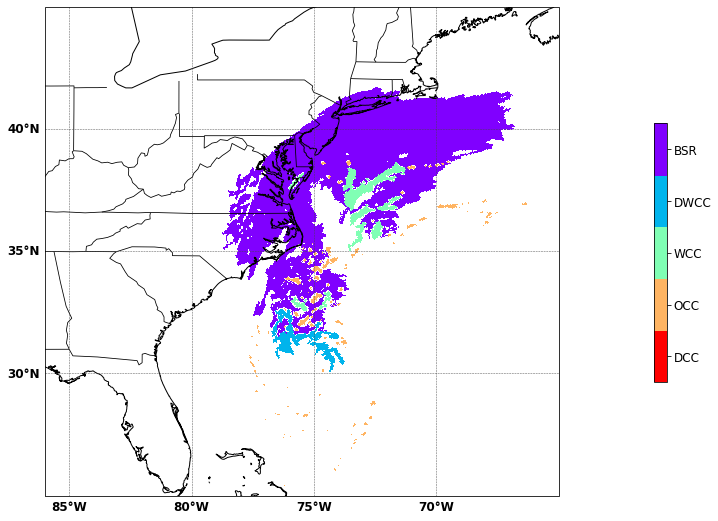

In [12]:
## Open file:
file_date_time = dt.datetime(2005, 10, 25, 0, 0, 0, tzinfo=pytz.utc)
file_name_dict = set_input_names(file_date_time)
ds_wrf_dbz = xr.open_dataset(file_name_dict['dbz'])


fig = plt.figure(figsize=(12,9))
ax1 = new_map(fig)
# ax1 = plt.axes(projection = ccrs.LambertConformal(central_longitude=-100, central_latitude=40))
# ax1 = plt.axes(projection = ccrs.PlateCarree())

plotting_var = ds_wrf_dbz.Storm_Mode_str[0]
plotting_lon = ds_wrf_dbz.XLONG
plotting_lat = ds_wrf_dbz.XLAT

cf1 = ax1.pcolormesh( plotting_lon, plotting_lat, plotting_var # + plotting_var_2 + plotting_var_3
                    , cmap=plt.cm.get_cmap('rainbow_r', 5)
                    , vmin=1
                    , vmax=5
                    , shading='auto'
                    )
# cf1 = ax1.pcolormesh( plotting_lon, plotting_lat, plotting_var_2
#                     , cmap=plt.cm.get_cmap('rainbow_r', 4)
#                     , vmin=1
#                     , vmax=4
#                     , shading='auto'
#                     )
cf1.cmap.set_under('w')

## Title:
# cf1_title = plt.title( np.datetime_as_string(da_wrf_dbz.Time.data, unit='h')
#                      + ' / ' + wrf_sim_type
#                      + ' / Storm Mode'
#                      + ' ('  + thresholds_type + ')'
#                      ,fontsize=14 
#                      ,fontweight='bold'
#                      # ,loc='left'
#                      )
# plt.title('right', loc='right')

## Colorbar:
cbar_ax = fig.add_axes([0.92, 0.3, 0.015, 0.4])
cbar = fig.colorbar(cf1, 
                    cax=cbar_ax, 
                    fraction=0.04, 
                    ticks=np.arange(1, 6, 1), 
                    boundaries=np.arange(0.5, 6.5, 1))
cbar.ax.tick_params(labelsize=12)
cbar.set_ticklabels(['DCC', 'OCC', 'WCC', 'DWCC', 'BSR'])

## Save figure:
# fig_file_name = './' + np.datetime_as_string(da_wrf_dbz.Time.data, unit='h') + '_StormMode_.png'
# fig_file_name = './' + np.datetime_as_string(ds_wrf_dbz.Time.data, unit='h') + '_StormMode_' + thresholds_type[0:3] + '.png'

# plt.savefig(fig_file_name, bbox_inches='tight', dpi=300)
